### 尝试预测 ：Age & Gender classification task for messi!!!
- 调用face_recognition库对照片中的人脸位置进行裁剪后进行预测

In [1]:
# !conda install -y cmake
#  !pip install face_recognition

In [1]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import face_recognition

import numpy as np
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn

c:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_size = (224, 224)

test_transforms = albu.Compose([
    albu.Resize(*(np.array(image_size) * 1.25).astype(int)),
    albu.CenterCrop(*image_size),
    albu.Normalize(),
    ToTensorV2()
])

# of course better to move these definitions into separate file
class AgeGenderModel(nn.Module):
    """
    CNN model with 2 heads and SE-block
    with multitask model learns faster
    """
    def __init__(self, encoder, encoder_channels, 
                 age_classes, gender_classes, output_channels=512):
        super().__init__()
        
        # encoder features (resnet50 in my case)
        # output should be bs x c x h x w
        self.encoder = encoder
        
        # sqeeze-excite
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.downsample = nn.Conv2d(encoder_channels, output_channels, 1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.nonlin1 = nn.ReLU()
        
        self.excite = nn.Conv2d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.nonlin2 = nn.ReLU()
        
        self.age_head = nn.Conv2d(output_channels, age_classes, 1)
        self.gender_head = nn.Conv2d(output_channels, gender_classes, 1)
    
    def forward(self, x):
        features = self.encoder(x)
        features = self.squeeze(features)
        features = self.downsample(features)
        features = self.nonlin1(self.bn1(features))
        
        weights_logits = self.excite(features)
        features = features * weights_logits.sigmoid()
        features = self.nonlin2(self.bn2(features))
        
        age_logits = self.age_head(features).view(features.size(0), -1)
        gender_logits = self.gender_head(features).view(features.size(0), -1)
        return age_logits, gender_logits
    
    def inference(self, x, transform=None):
        """Inference one frame"""
        # TODO: move to model constructor
        age_cats = ["0-2", "3-6", "8-13", "15-20", "22-32", "34-43", "45-53", "55-100"]
        gender_cats = ["f", "m", "u"]
        if transform is not None:
            x = transform(image=x)['image'].unsqueeze(0).to("cuda")
        age_logits, gender_logits = self.forward(x)
        return age_cats[age_logits.squeeze(0).max(0)[1]], gender_cats[gender_logits.squeeze(0).max(0)[1]]


In [3]:
# !pip install timm
import timm
mobilenet_v3 = timm.create_model('tf_mobilenetv3_large_100', pretrained=False)
mobilenet_v3_encoder = nn.Sequential(*list(mobilenet_v3.children())[:-4])
model = AgeGenderModel(mobilenet_v3_encoder, 960, age_classes=8, gender_classes=3)
model.load_state_dict(torch.load("mobilenetv3_age.pth", map_location="cpu"))
model.eval()
_ = model.cuda()

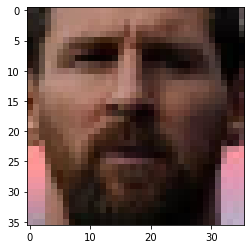

('34-43', 'm')


In [4]:
im = cv2.imread("images.jpg")[..., ::-1]
im = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)

for (top, right, bottom, left) in face_recognition.face_locations(im):
    face_crop = im[top:bottom, left:right].copy()
    plt.imshow(face_crop)
    plt.show()
    print(model.inference(face_crop, transform=test_transforms))

好准！!

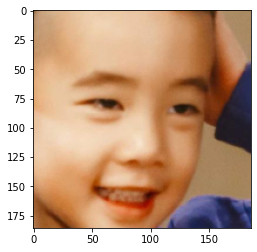

('3-6', 'm')


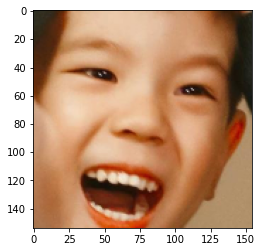

('3-6', 'm')


In [22]:
im1 = cv2.imread("test1.jpg")[..., ::-1]
im1 = cv2.resize(im1, (0, 0), fx=0.5, fy=0.5)

for (top, right, bottom, left) in face_recognition.face_locations(im1):
    face_crop = im1[top:bottom, left:right].copy()
    plt.imshow(face_crop)
    plt.show()
    print(model.inference(face_crop, transform=test_transforms))

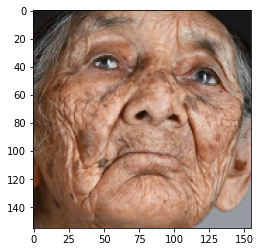

('55-100', 'f')


In [23]:
im2 = cv2.imread("test2.jpg")[..., ::-1]
im2 = cv2.resize(im2, (0, 0), fx=0.5, fy=0.5)

for (top, right, bottom, left) in face_recognition.face_locations(im2):
    face_crop = im2[top:bottom, left:right].copy()
    plt.imshow(face_crop)
    plt.show()
    print(model.inference(face_crop, transform=test_transforms))